# High- and Low-tide Composites

This notebook combines some of the lessons learnt in the first notebook
and applies them to an analysis that seeks to create cloud-free mosaic
images at either high or low tide. This can be helpful if you need to
run an analysis such as identifying seagrass, which is more difficult
when it's covered by water.

## Install and preparation

Download the Viti Levu tide model data using this code in a terminal:

```bash
rm -rf ~/tide_models && \
wget https://files.auspatious.com/coastlines/data/tide_models_fiji.zip -O /tmp/tide_models.zip && \
unzip /tmp/tide_models.zip -d /tmp/tide_models_temp && \
mv /tmp/tide_models_temp ~/tide_models
```

And install some packages:

```bash
pip install --upgrade pyTMD dea-tools
```

### Package import

First, we configure our Python package imports

In [1]:
from pystac_client import Client
from odc.stac import load
from dea_tools.coastal import pixel_tides

from dask.distributed import Client as DaskClient

from pathlib import Path
import odc.geo.xr  # noqa: F401
import folium
import rasterio

### Configuration

We're using the Element-84 STAC API to find Sentinel-2 data. This cell
also sets up a Dask client, so that we can lazy-load data and process
efficiently across multiple threads.

If you click the link to the Dashboard, you should be able to watch Dask
work, once we're at the stage where we compute the results.

In [2]:
# STAC Catalog URL
catalog = "https://earth-search.aws.element84.com/v1"

# Create a STAC Client
client = Client.open(catalog)

# Set up Dask
dask_client = DaskClient(n_workers=4, threads_per_worker=4)
dask_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 60.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40317,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 60.00 GiB
Comm: tcp://127.0.0.1:42985,Total threads: 4
Dashboard: http://127.0.0.1:37657/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:44657,


### Location and time

This step sets up the spatial and temporal extents as well as configuring
where the tide model is stored.

In [3]:
# Find a location you're interested in on Google Maps and copy the coordinates
# by right-clicking on the map and clicking the coordinates

# These coords are in the order Y then X, or Latitude then Longitude
coords = -18.175, 178.429  # Suva, Fiji
buffer = 0.1
bbox = (coords[1] - buffer, coords[0] - buffer, coords[1] + buffer, coords[0] + buffer)

datetime = "2023/2024"

# Tide data and config
home = Path("~")
tide_data_location = f"{home}/Data/tide_models_fiji"

## Find and load data

First, search the STAC API for Sentinel-2 scenes over our study site

In [4]:
items = client.search(
    collections=["sentinel-2-c1-l2a"],
    bbox=bbox,
    datetime=datetime
).item_collection()

print(f"Found {len(items)} STAC items")

Found 592 STAC items


### Load

Next, we use `odc-stac` to load data.

In [5]:
data = load(
    items,
    bands=["red", "green", "blue", "swir16", "cloud", "scl"],
    bbox=bbox,
    groupby="solar_day",
    chunks={"x": 2048, "y": 2048},
)

data

<xarray.Dataset> Size: 14GB
Dimensions:      (y: 2231, x: 2134, time: 290)
Coordinates:
  * y            (y) float64 18kB 8.001e+06 8.001e+06 ... 7.979e+06 7.979e+06
  * x            (x) float64 17kB 6.405e+05 6.405e+05 ... 6.618e+05 6.618e+05
    spatial_ref  int32 4B 32760
  * time         (time) datetime64[ns] 2kB 2023-01-01T22:30:52.805000 ... 202...
Data variables:
    red          (time, y, x) uint16 3GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 3GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 3GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir16       (time, y, x) uint16 3GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    cloud        (time, y, x) uint8 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    scl          (time, y, x) uint8 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

### Cloud masking

Masking out clouds is important, so that we can make a cloud-free mosaic
using as many pixels as possible. In the previous example, we selected
Landsat scenes that had less than a certain percentage of clouds. This method
is good, but potentially loses valuable data by discarding the more cloudy
scenes.

In [6]:
# 1: defective, 3: shadow, 8: med confidence cloud, 9: high confidence cloud
mask_flags = [0, 3, 8, 9]

cloud_mask = data.scl.isin(mask_flags)

masked = data.where(~cloud_mask).drop_vars("scl")

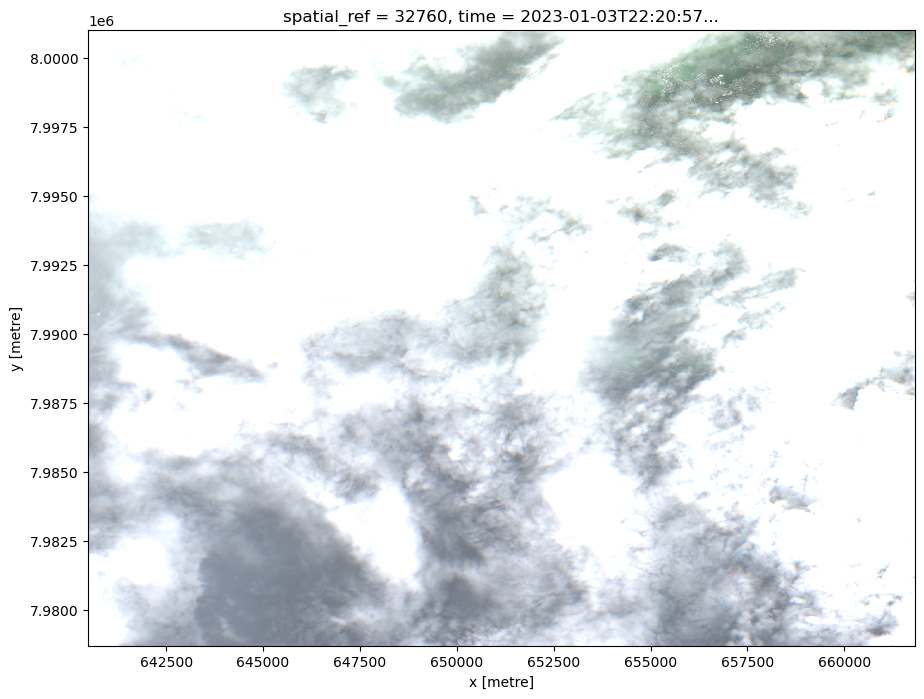

In [7]:
# Let's compare before and after

# Before
data[["red", "green", "blue"]].isel(time=1).to_array().plot.imshow(size=8, vmin=1000, vmax=4000)

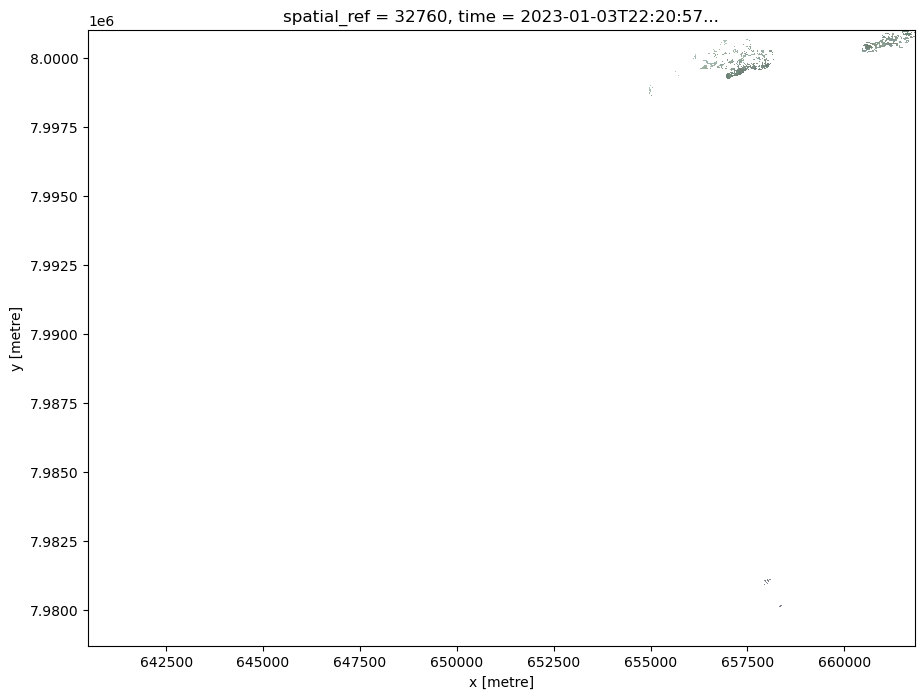

In [8]:
# After
masked[["red", "green", "blue"]].isel(time=1).to_array().plot.imshow(size=8, vmin=1000, vmax=4000)

### Tide modelling

This next cell annotates the data with the height of the tide at
the time the scene was captured. We use this information to select
the scenes at the top and bottom 30% of tides.

In [9]:
tide_data_location = "~/tide_models/tide_models_fiji"

In [10]:
# Annotate the data with the tide height
tides_lowres = pixel_tides(
    masked, resample=False, directory=tide_data_location, model="FES2022", dask_compute=True
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2022 in parallel


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

Returning low resolution tide array


In [11]:
lowest, highest = tides_lowres.quantile([0.3, 0.7]).values

low_scenes = tides_lowres.where(tides_lowres < lowest, drop=True)
high_scenes = tides_lowres.where(tides_lowres > highest, drop=True)

data_low = masked.sel(time=low_scenes.time)
data_high = masked.sel(time=high_scenes.time)

print(f"Found {len(data_low.time)} low tide days and {len(data_high.time)} high tide days out of {len(data.time)} days")

Found 89 low tide days and 89 high tide days out of 290 days


## Compute and visualise

This next cell creates a median of the high or low tide scenes. The
function call `compute()` at the end tells Dask to do the work of
downloading data and running the computation.

In [ ]:
median_low = data_low.median("time").compute()
median_high = data_high.median("time").compute()

/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
2025-01-13 02:20:42,404 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2025-01-13 02:20:44,078 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2025-01-13 02:20:45,528 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%

### Visualisation

First we are going to visualise just the high-tide scene. If this looks
good, the next step is to create an index, which will highlight areas that
are likely to be land and water, and we can see the difference between
low and high tide clearly. Each visualisation is done using an interactive
map.

In [ ]:
# Assuming median_low is an xarray.DataArray or xarray.Dataset
median_high.rio.to_raster(
    "south_suva_coast_high_tide.tif",
    driver="COG",
    compress="DEFLATE",  # Compression options, e.g., 'LZW', 'DEFLATE'
    dtype=rasterio.float32  # Ensure data type is correct
)

In [ ]:
median_low.odc.explore(vmin=1000, vmax=4000)

In [ ]:
median_high.odc.explore(vmin=1000, vmax=4000)

In [ ]:
# Calculate MNDWI
median_low["mndwi"] = (median_low.green - median_low.swir16) / (median_low.green + median_low.swir16)
median_high["mndwi"] = (median_high.green - median_high.swir16) / (median_high.green + median_high.swir16)

In [ ]:
# Plot LOW and HIGH MNDWI on the same map
m = folium.Map()

arguments = {
    "cmap": "RdBu",
    "vmin": -0.5,
    "vmax": 0.5,
}

# Plot each sample image with different colormap
median_low.mndwi.odc.add_to(m, name="low", **arguments)
median_high.mndwi.odc.add_to(m, name="high", **arguments)

folium.LayerControl().add_to(m)
m.fit_bounds(median_low.odc.map_bounds())
m